<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Classification Workflow 1
              
</p>
</div>

Data Science Cohort Live NYC 2023
<p>Phase 3</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

# ConfusionMatrixDisplayis added in the latest version of scikit-learn
# if you are running an older version, comment out the next line and just use plot_confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay

# Objectives

> The goal here is to illustrate a possible workflow for classification modeling with `sklearn`'s `LogisticRegression` model.


- Formulate and implement an iterative modeling workflow

# Modeling Walkthrough

Caution! This notebook is very long and we will likely not get through it all. But the good news is that the modeling process is *iterative* and so after a few of those iterations you should get the hang of it!

Build a model based on the [Titanic dataset](https://www.kaggle.com/c/titanic/data) that predicts whether a given person survived or not

# Modeling Steps

## Data Preparation
1. Explore data
2. Feature Selection
3. Separate out values for imputation
4. Impute missing values
5. One-hot encode categorical data
6. Scale values







## Fine Tuning
7. Build a model
8. Evaluate performance
9. Make changes in an attempt to improve the model
10. Demonstrate improvement was made

## The Data

This dataset has the following columns:

| Variable | Definition | Key |
| -------- | ---------- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age in years | |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

## Initial Data Understanding and Preparation

Open up the file, get everything into `X` features and `y` target variables, divided into train and test.

In [2]:
df = pd.read_csv("data/titanic.csv")

In [ ]:
df.head()

Which columns do you think we can let go of?

In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


What do you notice?


<details>
    <summary><b><u>Observations</u></b></summary>

38% Survived

Missing values in Age

Its seems like some didn't pay

Outliers in Fair/Sibsp look at mean and max
</details>


# 1st Model - Logistic Regression

Let's use a logistic regression and compare its performance.

We're going to specifically avoid any regularization (the default) to see how the model does with little change. So we'll pass `None` to the `penalty` parameter to not use any regularization. 

# Data Preparation

> Note: you can and should add features incrementally in a "real" modeling context.  The engineering effort of encoding the variables can be non-trivial!  But here let's assume that it's not too much work to encode all of them.

In [4]:
df = pd.read_csv("data/titanic.csv")
df.shape

(891, 12)

In [5]:
#check data types 
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
# Check for missing target values
df.Survived.isnull().sum()

0

In [7]:
# Feature Selection
X = df.drop(['PassengerId','Name','Ticket','Embarked', 'Survived'],axis=1)
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

In [8]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin'], dtype='object')

## Handling Missing Values

1. Drop missing values
2. Imputation
3. Impute and catalog where you imputed missing values

In [9]:
print(X_train.isna().sum())


Pclass      0
Sex         0
Age       139
SibSp       0
Parch       0
Fare        0
Cabin     514
dtype: int64


In [10]:
a = (X_train['Age'].isna().sum()/X_train.shape[0]).round(2) * 100
c = (X_train['Cabin'].isna().sum()/X_train.shape[0]).round(2) * 100
print(f'{a}% of Age is missing.')
print(f'{c}% of Cabin is missing.')

21.0% of Age is missing.
77.0% of Cabin is missing.


Now let's fill in those missing values.  This takes two separate imputers because we want to use the mean for numeric data and the majority class for categorical data.

The `SimpleImputer` class fills in the mean value by default, so we'll have to override that for the categorical columns.

In [15]:
X_train_numeric = X_train.select_dtypes(exclude=['object'])
X_train_numeric.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [16]:
X_train_categorical = X_train.select_dtypes(include=['object'])
X_train_categorical.columns


Index(['Sex', 'Cabin'], dtype='object')

In [17]:
# uses mean
numeric_imputer = SimpleImputer()
numeric_imputer.fit(X_train_numeric)

SimpleImputer()

In [18]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
categorical_imputer.fit(X_train_categorical)

SimpleImputer(strategy='most_frequent')

We'll build a function here to minimize our work of imputation:

In [19]:
def impute_missing_values(X, imputer):
    """
    Given a DataFrame and an imputer, use the imputer to fill in all
    missing values in the DataFrame
    """
    imputed_array = imputer.transform(X)
    imputed_df = pd.DataFrame(imputed_array, columns=X.columns, index=X.index)
    return imputed_df

In [20]:
X_train_numeric = impute_missing_values(X_train_numeric, numeric_imputer)
X_train_categorical = impute_missing_values(X_train_categorical, categorical_imputer)

Double-check to make sure that all of the missing values are gone:

In [21]:
X_train_imputed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train_imputed.isna().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
Sex       0
Cabin     0
dtype: int64

In [22]:
X_train_imputed

,Pclass,Age,SibSp,Parch,Fare,Sex,Cabin
316,2.0,24.000000,1.0,0.0,26.000,female,C23 C25 C27
289,3.0,22.000000,0.0,0.0,7.750,female,C23 C25 C27
344,2.0,36.000000,0.0,0.0,13.000,male,C23 C25 C27
220,3.0,16.000000,0.0,0.0,8.050,male,C23 C25 C27
11,1.0,58.000000,0.0,0.0,26.550,female,C103
...,...,...,...,...,...,...,...
732,2.0,29.510718,0.0,0.0,0.000,male,C23 C25 C27
695,2.0,52.000000,0.0,0.0,13.500,male,C23 C25 C27
454,3.0,29.510718,0.0,0.0,8.050,male,C23 C25 C27
537,1.0,30.000000,0.0,0.0,106.425,female,C23 C25 C27


## One-Hot Encoding

Now that there are no missing values, convert all of the categorical features into numbers.

In [23]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [24]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    #ohe_df = pd.DataFrame(feature_array, columns=ohe.get_feature_names_out(), index=X.index)
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [25]:
categorical_feature_names = ["Sex", 'Cabin']



encoders = {}

for categorical_feature in categorical_feature_names:
    ohe,X_train_imputed = encode_and_concat_feature_train(X_train_imputed, categorical_feature)
    encoders[categorical_feature] = ohe

In [26]:
encoders

{'Sex': OneHotEncoder(handle_unknown='ignore'),
 'Cabin': OneHotEncoder(handle_unknown='ignore')}

In [27]:
X_train_imputed

,Pclass,Age,SibSp,Parch,Fare,female,male,A10,A14,A16,...,E68,E77,E8,F E69,F G63,F33,F38,F4,G6,T
316,2.0,24.000000,1.0,0.0,26.000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289,3.0,22.000000,0.0,0.0,7.750,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344,2.0,36.000000,0.0,0.0,13.000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220,3.0,16.000000,0.0,0.0,8.050,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1.0,58.000000,0.0,0.0,26.550,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,2.0,29.510718,0.0,0.0,0.000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,2.0,52.000000,0.0,0.0,13.500,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
454,3.0,29.510718,0.0,0.0,8.050,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537,1.0,30.000000,0.0,0.0,106.425,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 1st Model 

Let's run a logistic regression:

In [28]:
logreg_model = LogisticRegression(random_state=2022, penalty = None)
logreg_model.fit(X_train_imputed, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty=None, random_state=2022)

What happened there? 


<details>
    <summary><b><u>Answer</u></b></summary>

It wasn't able to find the minimum with this number of steps in gradient descent.
</details>

## Hyperparameter Adjustments to the Model

Let's try a couple of stopgap measures to get the model to run.

### More Iterations

Allows for more iterations to find a solution

In [29]:
logreg_model_more_iterations = LogisticRegression(
                                                random_state=2022, 
                                                penalty=None, 
                                                max_iter=5000
)
logreg_model_more_iterations.fit(X_train_imputed, y_train)

LogisticRegression(max_iter=5000, penalty=None, random_state=2022)

### More Regularization

Remember that the `C` parameter is the inverse of the regularization strength.

> Note: We could do regularization but we should first scale our features. We're actually going to skip this hyperparameter until we scale our data 

### Higher Tolerance

A higher tolerance means that the model will stop training earlier (when predictions and true values aren't as close as they could be).

In [30]:
logreg_model_higher_tolerance = LogisticRegression(
                                                random_state=2022, 
                                                penalty=None, 
                                                tol=25
)
logreg_model_higher_tolerance.fit(X_train_imputed, y_train)

LogisticRegression(penalty=None, random_state=2022, tol=25)

## Model Evaluation

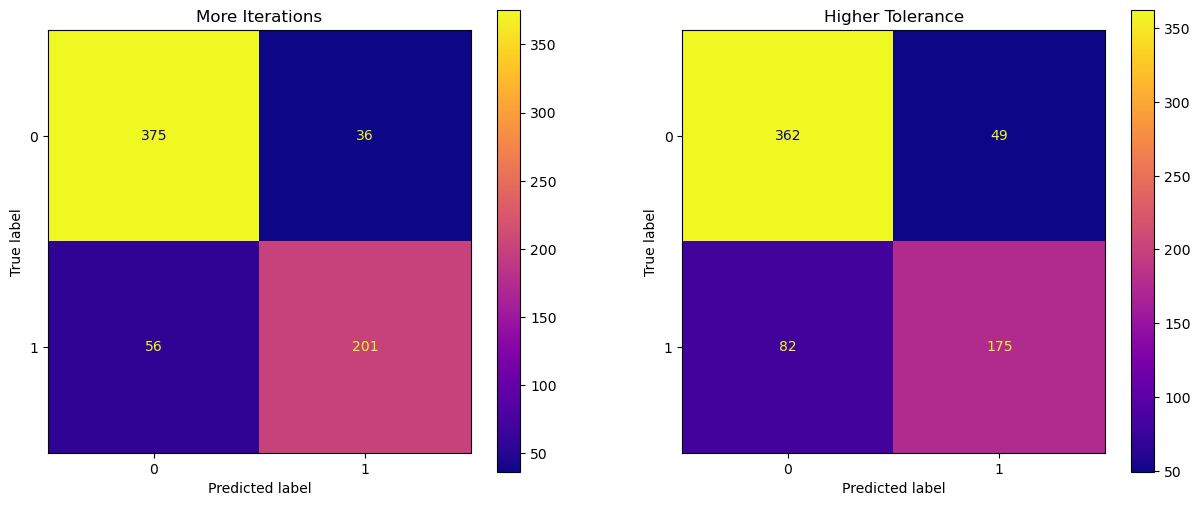

In [31]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].set_title("More Iterations")
axes[1].set_title("Higher Tolerance")

#plot_confusion_matrix(logreg_model_more_iterations, X_train_imputed, y_train, ax=axes[0], cmap="plasma")
#plot_confusion_matrix(logreg_model_higher_tolerance, X_train_imputed, y_train, ax=axes[1], cmap="plasma");

ConfusionMatrixDisplay.from_estimator(logreg_model_more_iterations, X_train_imputed, y_train, ax=axes[0], cmap="plasma")
ConfusionMatrixDisplay.from_estimator(logreg_model_higher_tolerance, X_train_imputed, y_train, ax=axes[1], cmap="plasma");

In [32]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [33]:
logreg_model_more_iterations_results = ModelWithCV(
                                        logreg_model_more_iterations,
                                        'more_iterations',
                                        X_train_imputed,
                                        y_train
)
    
logreg_model_higher_tolerance_results = ModelWithCV(
                                        logreg_model_higher_tolerance,
                                        'higher_tolerance',
                                        X_train_imputed,
                                        y_train
)

model_results = [
    logreg_model_more_iterations_results,
    logreg_model_higher_tolerance_results
]





CV Results for `more_iterations` model:
            0.78602 ± 0.04916 accuracy
        
CV Results for `higher_tolerance` model:
            0.80242 ± 0.03925 accuracy
        


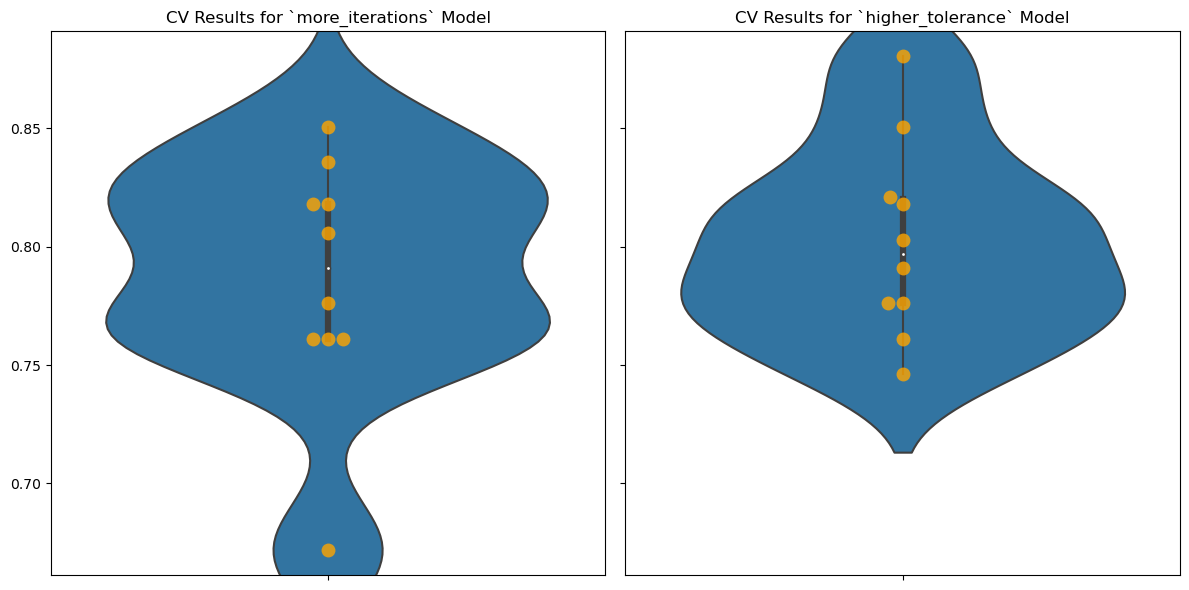

In [34]:
f,axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

for ax, result in zip(axes, model_results):
    ax = result.plot_cv(ax)
    result.print_cv_summary()
plt.tight_layout();

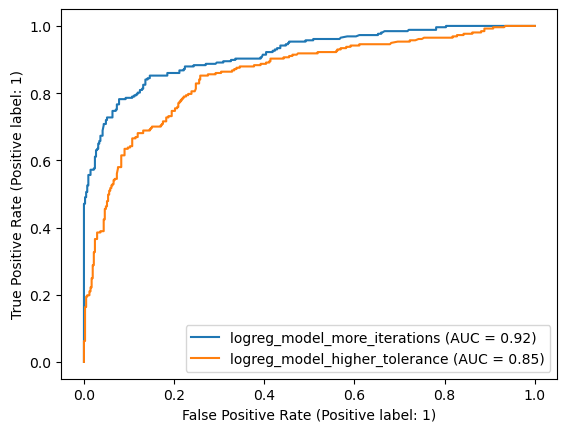

In [35]:
fig, ax = plt.subplots()

#plot_roc_curve(logreg_model_more_iterations, X_train_imputed, y_train, name='logreg_model_more_iterations', ax=ax)
#plot_roc_curve(logreg_model_higher_tolerance, X_train_imputed, y_train, name='logreg_model_higher_tolerance', ax=ax);

RocCurveDisplay.from_estimator(logreg_model_more_iterations, X_train_imputed, y_train, 
                name='logreg_model_more_iterations', ax=ax)
RocCurveDisplay.from_estimator(logreg_model_higher_tolerance, X_train_imputed, y_train, 
               name='logreg_model_higher_tolerance', ax=ax);



# Even More Data Preparation - Scaling

However, recall we should scale all of the features, so the model isn't overly penalizing age and fare.

In [36]:
#We need to perform Feature Scaling when we are dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) 

scaler = StandardScaler()
scaler.fit(X_train_imputed)

StandardScaler()

In [37]:
def scale_values(X, scaler):
    """
    Given a DataFrame and a fitted scaler, use the scaler to scale all of the features
    """
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [38]:
X_train_scaled = scale_values(X_train_imputed, scaler)

In [39]:
X_train_scaled.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,A10,A14,A16,...,E68,E77,E8,F E69,F G63,F33,F38,F4,G6,T
316,-0.355384,-0.431247,0.455866,-0.466265,-0.134641,1.389181,-1.389181,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.0548,-0.03872,-0.03872,-0.067166,-0.03872,-0.03872,-0.067166,-0.03872
289,0.831598,-0.587758,-0.481114,-0.466265,-0.477973,1.389181,-1.389181,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.0548,-0.03872,-0.03872,-0.067166,-0.03872,-0.03872,-0.067166,-0.03872
344,-0.355384,0.507825,-0.481114,-0.466265,-0.379206,-0.719848,0.719848,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.0548,-0.03872,-0.03872,-0.067166,-0.03872,-0.03872,-0.067166,-0.03872
220,0.831598,-1.057294,-0.481114,-0.466265,-0.472329,-0.719848,0.719848,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.0548,-0.03872,-0.03872,-0.067166,-0.03872,-0.03872,-0.067166,-0.03872
11,-1.542366,2.229456,-0.481114,-0.466265,-0.124294,1.389181,-1.389181,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.0548,-0.03872,-0.03872,-0.067166,-0.03872,-0.03872,-0.067166,-0.03872


# 3rd Model - After Scaling

Now that the data is scaled, let's see if we can fit the model without tweaking any hyperparameters.

In [40]:
logreg_model = LogisticRegression(random_state=2022)
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=2022)

## Model Evaluation, Part 4

Now that we are able to run a logistic regression with default hyperparameters, let's see how that performs.

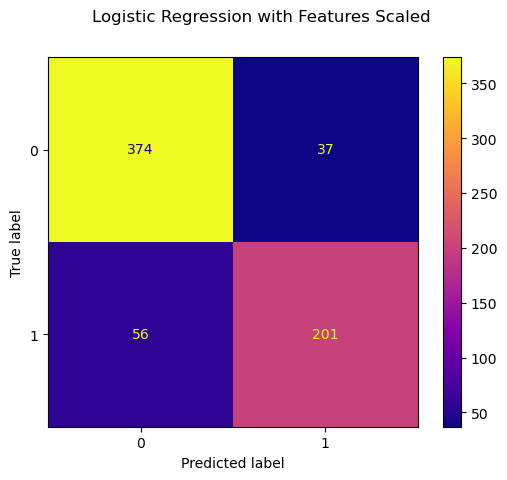

In [41]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Features Scaled")

#plot_confusion_matrix(logreg_model, X_train_scaled, y_train, ax=ax, cmap="plasma");
ConfusionMatrixDisplay.from_estimator(logreg_model, X_train_scaled, y_train, ax=ax, cmap="plasma");

In [42]:
scaled_features_results = ModelWithCV(
                            logreg_model,
                            'scaled_features',
                            X_train_scaled,
                            y_train
)

CV Results for `scaled_features` model:
            0.79647 ± 0.04460 accuracy
        


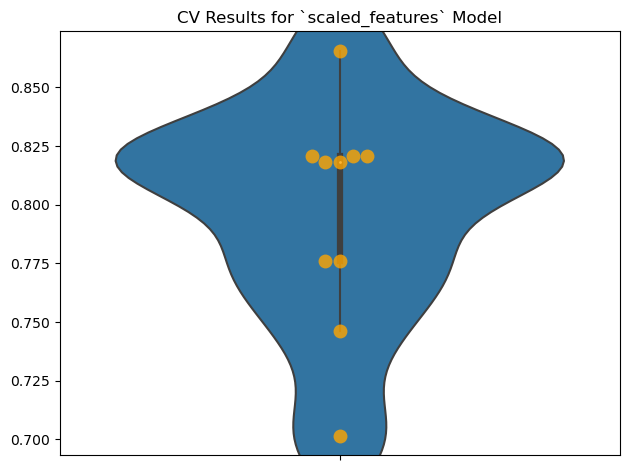

In [43]:
# Saving variable for convenience
model_results = scaled_features_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

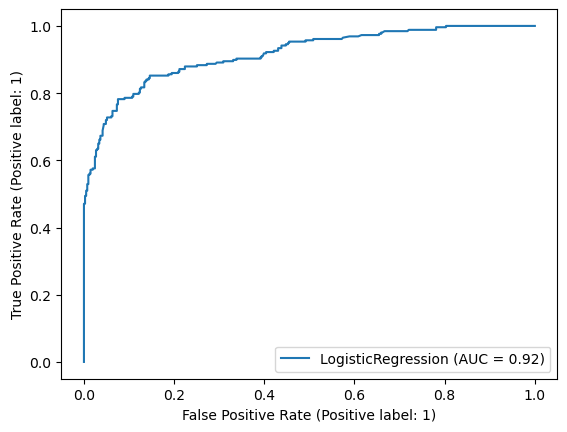

In [44]:
#plot_roc_curve(logreg_model, X_train_scaled, y_train)
RocCurveDisplay.from_estimator(logreg_model, X_train_scaled, y_train);

... this might be overfitting.

## Hyperparameter Adjustment

### Different Regularization Strengths

Let's try out some different regularization penalties to see if we can improve the test data score a bit.

In [45]:
model_results = [scaled_features_results]
C_values = [0.0001, 0.001, 0.01, 0.1, 1]

for c in C_values:
    logreg_model = LogisticRegression(random_state=2022, C=c) #solver = "liblinear"
    logreg_model.fit(X_train_scaled, y_train)
    # Save Results
    new_model_results = ModelWithCV(
                            logreg_model,
                            f'scaled_features_c{c:e}',
                            X_train_scaled,
                            y_train
    )
    model_results.append(new_model_results)
    new_model_results.print_cv_summary()

CV Results for `scaled_features_c1.000000e-04` model:
            0.61529 ± 0.00532 accuracy
        
CV Results for `scaled_features_c1.000000e-03` model:
            0.70647 ± 0.03710 accuracy
        
CV Results for `scaled_features_c1.000000e-02` model:
            0.80981 ± 0.03636 accuracy
        
CV Results for `scaled_features_c1.000000e-01` model:
            0.80090 ± 0.03267 accuracy
        
CV Results for `scaled_features_c1.000000e+00` model:
            0.79647 ± 0.04460 accuracy
        


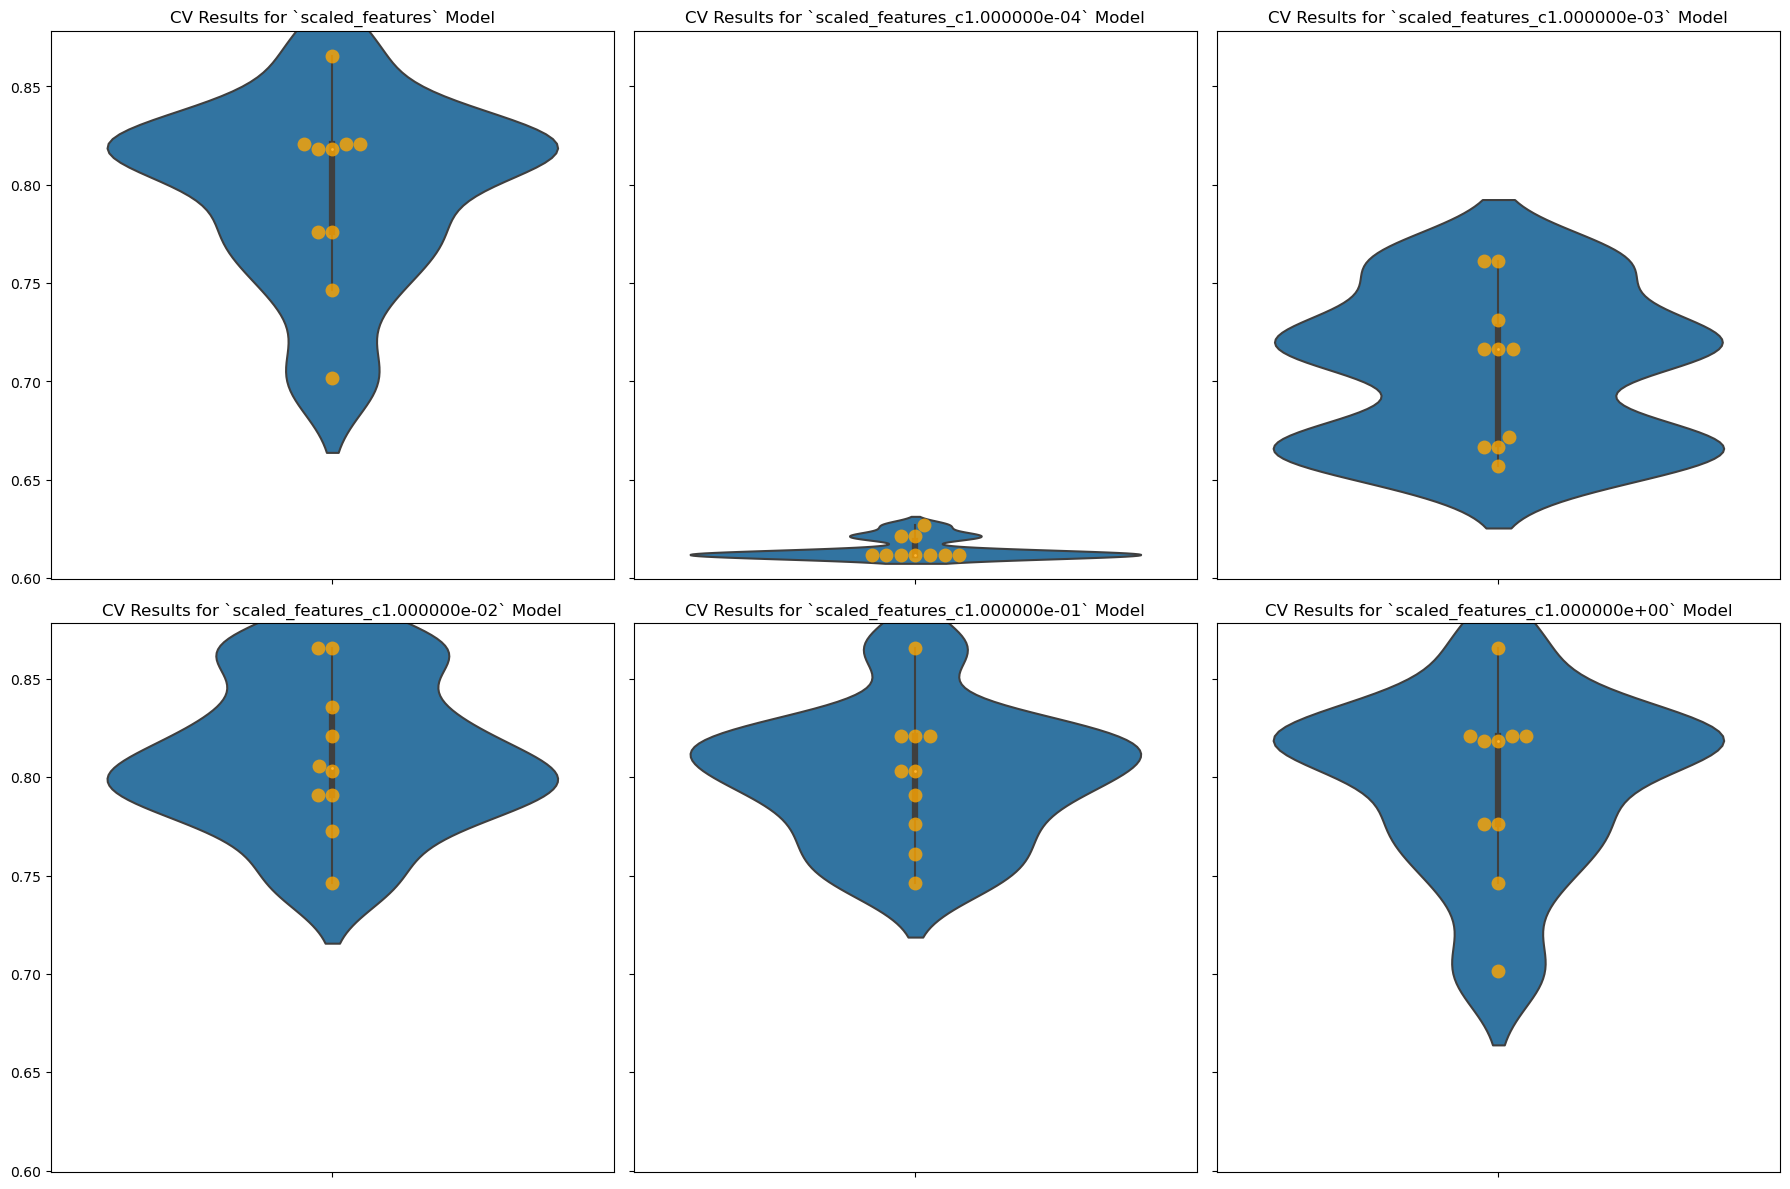

In [46]:
f,axes = plt.subplots(ncols=3, nrows=2, sharey='all', figsize=(18, 12))

for ax,result in zip(axes.ravel(),model_results):
    ax = result.plot_cv(ax)

plt.tight_layout();

It looks like C = .01 value is pretty optimal for this solver.

In [ ]:
model_results = [scaled_features_results]
scaled_features_cross_val_score = scaled_features_results.cv_results

### Different Solvers

In [ ]:
logreg_model = LogisticRegression(random_state=2022, C=0.01)
logreg_model.fit(X_train_scaled, y_train)
ModelWithCV(logreg_model, "l2", X_train_scaled, y_train).print_cv_summary()

In [ ]:
logreg_model = LogisticRegression(random_state=2022, solver="liblinear", C=.01)
logreg_model.fit(X_train_scaled, y_train)
ModelWithCV(logreg_model, "liblinear", X_train_scaled, y_train).print_cv_summary()


In [ ]:
# Save for later comparison
model_results.append(
    ModelWithCV(
        logreg_model, 
        'C:0.01',
        X_train_scaled,
        y_train
    )
)

In [ ]:
# Save for later comparison
model_results.append(
    ModelWithCV(
        logreg_model, 
        'solver:liblinear_C:0.01',
        X_train_scaled,
        y_train
    )
)

# Plot both  models
f,axes = plt.subplots(ncols=2, sharey='all', figsize=(12, 6))

model_results[1].plot_cv(ax=axes[0])
model_results[-1].plot_cv(ax=axes[1])

plt.tight_layout();

In [ ]:
logreg_model = LogisticRegression(random_state=2022, C =.01)
logreg_model.fit(X_train_scaled, y_train)

fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Features Scaled, Hyperparameters Tuned)")

#plot_confusion_matrix(logreg_model, X_train_scaled, y_train, ax=ax, cmap="plasma");
ConfusionMatrixDisplay.from_estimator(logreg_model, X_train_scaled, y_train, ax=ax, cmap="plasma");

## `SelectFromModel`

The last model is probably overfitting. We might try thinning out the number of features by eliminating the ones with small modeling coefficients using [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

In [ ]:
selector = SelectFromModel(logreg_model)

selector.fit(X_train_scaled, y_train)

We're using the default threshold here:

In [ ]:
thresh = selector.threshold_
thresh

Let's get a sense of which features will be eliminated:

In [ ]:
coefs = selector.estimator_.coef_
coefs

In [ ]:
coefs.shape

In [ ]:
X_train_scaled.shape

In [ ]:
selector.get_support()

In [ ]:
sup = selector.get_support()
unique, counts = np.unique(sup, return_counts=True)
print(np.asarray((unique, counts)).T)


In [ ]:
dict(zip(X_train_scaled.columns, selector.get_support()))

In [ ]:
def select_important_features(X, selector):
    """
    Given a DataFrame and a selector, use the selector to choose
    the most important columns
    """
    imps = dict(zip(X.columns, selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,
                               columns=[col for col in X.columns if imps[col]],
                               index=X.index)
    return selected_df

In [ ]:
X_train_selected = select_important_features(X=X_train_scaled, selector=selector)

In [ ]:
X_train_selected.head()

In [ ]:
logreg_sel = LogisticRegression(random_state=2022,C =.01)

logreg_sel.fit(X_train_selected, y_train)

Probably still overfitting, but let's call this our final model!

# Final Model Evaluation

Now that we have a final model, run X_test through all of the preprocessing steps so we can evaluate the model's performance

In [ ]:
X_test_no_transformations = X_test.copy()

In [ ]:
numeric_feature_names = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# separate out values for imputation
X_test_numeric = X_test_no_transformations[numeric_feature_names]
X_test_categorical = X_test_no_transformations[categorical_feature_names]

In [ ]:
# impute missing values
X_test_numeric = impute_missing_values(X_test_numeric, numeric_imputer)
X_test_categorical = impute_missing_values(X_test_categorical, categorical_imputer)
X_test_final = pd.concat([X_test_numeric, X_test_categorical], axis=1)


In [ ]:
# one-hot encode categorical data
for categorical_feature in categorical_feature_names:
    X_test_final = encode_and_concat_feature(X_test_final,
                                       categorical_feature, encoders[categorical_feature])

In [ ]:
# scale values
X_test_scaled = scale_values(X_test_final, scaler)

In [ ]:
# select features
X_test_selected = select_important_features(X_test_scaled, selector)

In [ ]:
X_test_selected.head()

Create a model with the relevant hyperparameters, fit, and score

In [ ]:
final_model = LogisticRegression(random_state=2022, C =.01)
final_model.fit(X_train_selected, y_train)

final_model.score(X_test_selected, y_test)

## Compare the past models

In [ ]:
# Create a way to categorize our different models
model_candidates = [
  
    {
        'name':'logreg_model_more_iterations'
        ,'model':logreg_model_more_iterations
        ,'X_test':X_test_final
        ,'y_test':y_test
    },
    {
        'name':'logreg_model_higher_tolerance'
        ,'model':logreg_model_higher_tolerance
        ,'X_test':X_test_final
        ,'y_test':y_test
    },
    {
        'name':'final_model'
        ,'model':final_model
        ,'X_test':X_test_selected
        ,'y_test':y_test
    }
]

In [ ]:
final_scores_dict = {
    "Model Name": [candidate.get('name') for candidate in model_candidates],
    "Mean Accuracy": [
        candidate.get('model').score(
                                candidate.get('X_test'), 
                                candidate.get('y_test')
        ) 
        for candidate in model_candidates
    ]
    
}
final_scores_df = pd.DataFrame(final_scores_dict).set_index('Model Name')
final_scores_df

Final comparison of confusion matrices

In [ ]:
nrows = 2
ncols = math.ceil(len(model_candidates)/nrows)

fig, axes = plt.subplots(
                nrows=nrows,
                ncols=ncols,
                figsize=(12, 6)
)
fig.suptitle("Confusion Matrix Comparison")

# Turn off all the axes (in case nothing to plot); turn on while iterating over
[ax.axis('off') for ax in axes.ravel()]


for i,candidate in enumerate(model_candidates):
    # Logic for making rows and columns for matrices
    row = i // 2
    col = i % 2
    ax = axes[row][col]
    
    ax.set_title(candidate.get('name'))
    ax.set_axis_on() 
    #cm_display = plot_confusion_matrix(candidate.get('model'), candidate.get('X_test'), candidate.get('y_test'),
     #               normalize='true', cmap='plasma', ax=ax,)
    cm_display = ConfusionMatrixDisplay.from_estimator(
                    candidate.get('model'),
                    candidate.get('X_test'),
                    candidate.get('y_test'),
                    normalize='true',
                    cmap='plasma',
                    ax=ax,
                    
    )
   
    cm_display.im_.set_clim(0, 1)

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()

# Plot only the last models we created (so it's not too cluttered)
for model_candidate in model_candidates[0:]:
    #plot_roc_curve(
    RocCurveDisplay.from_estimator(
        model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    )


Where was there data leakage?

What you add to data preparation process?

How would select your features?

How would deal with outliers?

# Exercise

Build and iterate on a logistic regression model of **color** for the diamonds dataset! Maximize accuracy.

In [ ]:
diamonds = sns.load_dataset('diamonds')